In [1]:
import os
import pandas as pd
import numpy as np
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt
import rasterio
from rasterio.plot import show
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from pathlib import Path
from matplotlib.ticker import ScalarFormatter

In [2]:
meta_df = pd.read_csv("/net/scratch/jmoehring/meta/ortho_metadata_annot.csv")
meta_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   filename                   263 non-null    object 
 1   project_id                 263 non-null    object 
 2   authors_image              263 non-null    object 
 3   acquisition_date_month     263 non-null    float64
 4   acquisition_date_day       262 non-null    float64
 5   acquisition_date_year      263 non-null    float64
 6   acquisition_date_precise   157 non-null    float64
 7   email                      0 non-null      float64
 8   label_type                 263 non-null    object 
 9   label_source               263 non-null    object 
 10  image_platform             263 non-null    object 
 11  image_spectral_properties  263 non-null    object 
 12  citation_doi               21 non-null     object 
 13  label_quality              263 non-null    float64

In [3]:
tile_folder = "/net/home/jmoehring/scratch/tiles_1024/switzerlandeth_rgb19/0.1/"
label_folder = "/net/home/jmoehring/tree_mortality_orthophotos/labels_and_aois"
north_symbol_path = "/net/home/jmoehring/scratch/north-symbol.png"

In [4]:
bad_contrast_tile = "/net/home/jmoehring/scratch/tiles_1024/spain_14_09_2023_sierra_de_baza_5_ortho/0.03/12360_4679.tif"
good_contrast_tile = (
    "/net/home/jmoehring/scratch/tiles_1024/uavforsat_DDH002_ortho/0.025/3507_1271.tif"
)
high_resolution_tile = "/net/home/jmoehring/scratch/tiles_1024/uavforsat_2020_CFB091_ortho/0.007/13397_17747.tif"
low_resolution_tile = (
    "/net/home/jmoehring/scratch/tiles_1024/switzerlandeth_rgb19/0.1/1031_9220.tif"
)

In [5]:
tile_no = 80
zoom = True

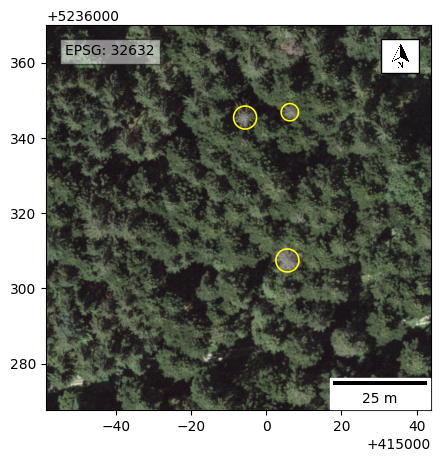

In [6]:
# Get the first GeoTIFF file in the folder
tile_files = [
    f
    for f in os.listdir(tile_folder)
    if (f.endswith((".tif", ".tiff")) and not f.__contains__("mask"))
]
tile_files.sort()
first_tile = tile_files[tile_no]
tile_path = os.path.join(tile_folder, first_tile)

# Construct the GeoPackage file name
tile_folder_name = Path(tile_folder).parent.name
gpkg_filename = f"{tile_folder_name}_polygons.gpkg"
gpkg_path = os.path.join(label_folder, gpkg_filename)

# Load the raster image
with rasterio.open(tile_path) as src:
    image = src.read()
    extent = rasterio.plot.plotting_extent(src)
    crs = src.crs
    transform = src.transform
    pixel_size_x = transform[0]
    pixel_size_y = -transform[4]

# Load the 'standing_deadwood' layer from the GeoPackage
gdf = gpd.read_file(gpkg_path, layer="standing_deadwood")

# Reproject the GeoDataFrame if necessary
if gdf.crs != crs:
    gdf = gdf.to_crs(crs)

# Plotting
fig, ax = plt.subplots(figsize=(5, 5))
show(image, ax=ax, extent=extent)
gdf.plot(ax=ax, facecolor="none", edgecolor="yellow", linewidth=1.2)

# Zoom in on the tile extent
if zoom:
    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])
    ax.set_aspect("equal")


class my_ScalarFormatter(ScalarFormatter):
    def format_data(self, value):
        return f"{value:.0f}"


ax.xaxis.set_major_formatter(my_ScalarFormatter())
ax.yaxis.set_major_formatter(my_ScalarFormatter())


# Add a scale bar
scalebar = ScaleBar(1, location="lower right", length_fraction=0.4)
ax.add_artist(scalebar)

# Add the EPSG label
epsg_code = crs.to_epsg()  # Extract the EPSG code from the CRS object
ax.text(
    0.05,
    0.95,
    f"EPSG: {epsg_code}",
    transform=ax.transAxes,
    fontsize=10,
    verticalalignment="top",
    bbox=dict(facecolor="white", alpha=0.5),
)
arr_img = plt.imread(north_symbol_path)
# add north symbol svg to the top right
im = OffsetImage(arr_img, zoom=0.01)
ab = AnnotationBbox(im, xycoords="axes fraction", xy=(0.92, 0.92))
ax.add_artist(ab)

# Display the plot
plt.savefig("/net/home/jmoehring/low_resolution_plot.png", bbox_inches="tight", dpi=300)
plt.show()

In [18]:
# Define a function to transform a point's CRS
def reproject_to_epsg_4326(row):
    original_crs = row["crs"]
    # Create a GeoDataFrame for the point with the specified CRS
    gdf = gpd.GeoDataFrame(
        geometry=gpd.points_from_xy([row["centroid_x"]], [row["centroid_y"]]),
        crs=original_crs,
    )
    # Transform to EPSG:4326
    gdf = gdf.to_crs("EPSG:4326")
    # Return the transformed coordinates
    return gdf.geometry.x[0], gdf.geometry.y[0]

In [19]:
# add EPSG:4326 centroid to metadata caluclated from the bounding box and the projection
meta_df["centroid_x"] = meta_df.apply(lambda x: (x["west"] + x["east"]) / 2, axis=1)
meta_df["centroid_y"] = meta_df.apply(lambda x: (x["south"] + x["north"]) / 2, axis=1)

meta_df[["centroid_x_4326", "centroid_y_4326"]] = meta_df.apply(
    reproject_to_epsg_4326, axis=1, result_type="expand"
)

In [22]:
# convert the metadata to a geodataframe with POINT geometry
meta_gdf = gpd.GeoDataFrame(
    meta_df,
    geometry=gpd.points_from_xy(meta_df["centroid_x_4326"], meta_df["centroid_y_4326"]),
    crs="EPSG:4326",
)

In [7]:
tile_path

'/net/home/jmoehring/scratch/tiles_1024/switzerlandeth_rgb19/0.1/1031_9220.tif'

In [8]:
eco_gdf = gpd.read_file("/net/scratch/jmoehring/meta/wwf_terr_ecos.shp")

In [9]:
eco_gdf_dissolved = eco_gdf.dissolve(by="BIOME").reset_index()

In [10]:
world = gpd.read_file(
    "/net/home/jmoehring/scratch/meta/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp"
)

In [11]:
biome_dict = {
    1: "Tropical and Subtropical Moist Broadleaf Forests",
    2: "Tropical and Subtropical Dry Broadleaf Forests",
    3: "Tropical and Subtropical Coniferous Forests",
    4: "Temperate Broadleaf and Mixed Forests",
    5: "Temperate Coniferous Forests",
    6: "Boreal Forests/Taiga",
    7: "Tropical and Subtropical Grasslands, Savannas, and Shrublands",
    8: "Temperate Grasslands, Savannas, and Shrublands",
    9: "Flooded Grasslands and Savannas",
    10: "Montane Grasslands and Shrublands",
    11: "Tundra",
    12: "Mediterranean Forests, Woodlands, and Scrub",
    13: "Deserts and Xeric Shrublands",
    14: "Mangroves",
}

In [12]:
# filter ecoregions that are not present in the meta data
eco_gdf_dissolved = eco_gdf_dissolved[
    eco_gdf_dissolved["BIOME"].isin(meta_df["biome"].unique())
]

In [13]:
eco_gdf_dissolved["BIOME_NAME"] = eco_gdf_dissolved["BIOME"].map(biome_dict)

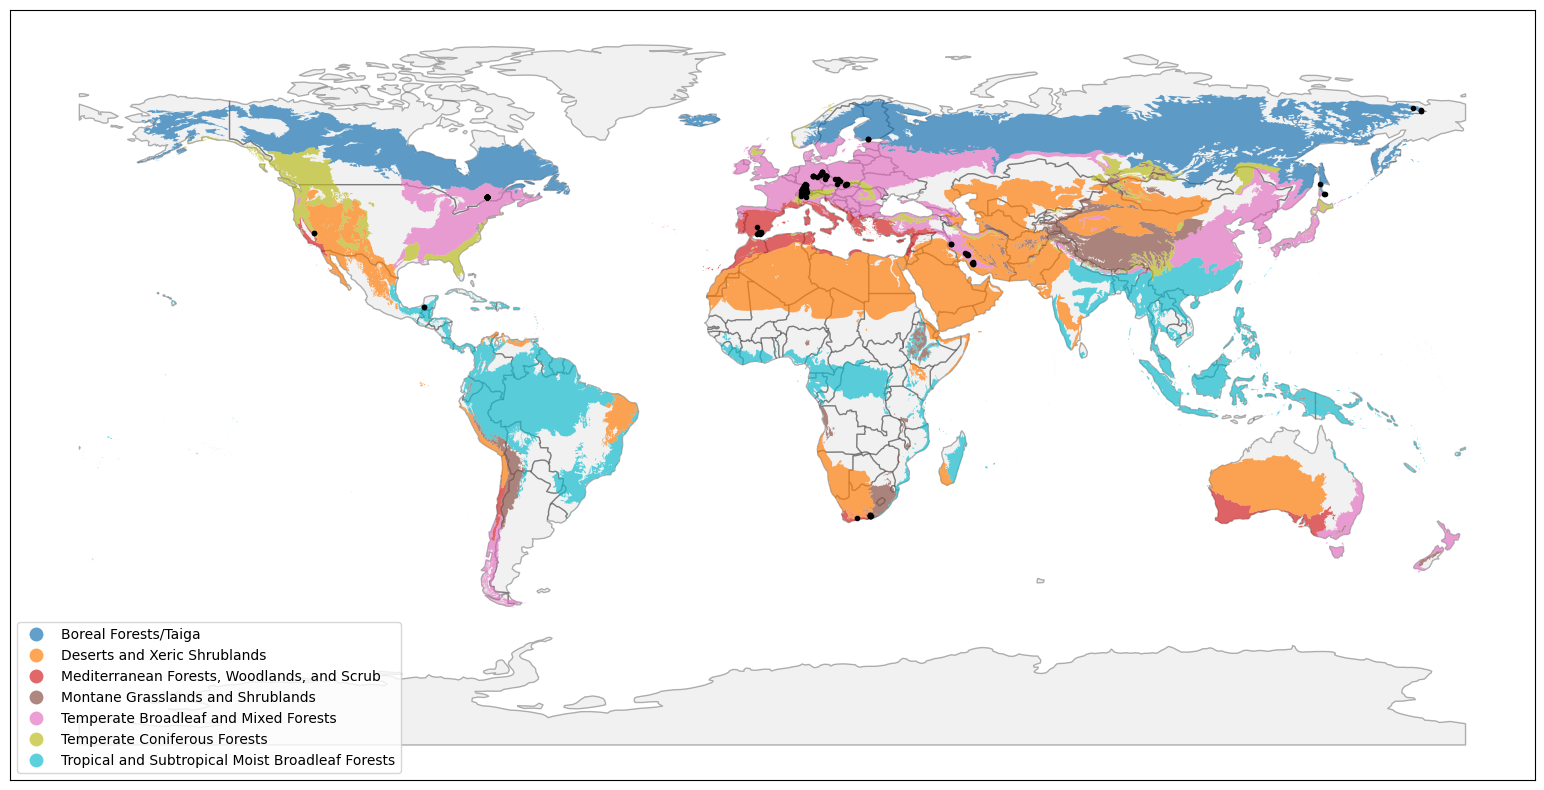

In [25]:
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot()

# plot a basic map of the world
world.plot(ax=ax, color="lightgray", edgecolor="black", alpha=0.3)

eco_gdf_dissolved.plot(
    ax=ax,
    legend=True,
    alpha=0.7,
    legend_kwds={"loc": "lower left"},
    categorical=True,
    column="BIOME_NAME",
)

# plot the tile centroids
meta_gdf.plot(ax=ax, color="black", markersize=9)

# turn off axis ticks
ax.set_xticks([])
ax.set_yticks([])

# set the plot title
# plt.title("Basic Map of World with GeoPandas")
plt.show()

In [6]:
df = pd.read_csv("/net/home/jmoehring/experiments/eval_runs/eval_20k_effnet.csv")

In [7]:
df["resolution"] = "1024"

In [3]:
experiments_dir = Path("/net/home/jmoehring/experiments")

In [4]:
df_512 = pd.read_csv(
    experiments_dir / "50k_biome_resolution_strat_pos_weight_512" / "eval.csv"
)
df_1024_0 = pd.read_csv(
    experiments_dir / "10k_biome_resolution_strat_pos_weight_1024_fold0" / "eval.csv"
)
df_1024_1 = pd.read_csv(
    experiments_dir / "10k_biome_resolution_strat_pos_weight_1024_fold1" / "eval.csv"
)
df_1024_2 = pd.read_csv(
    experiments_dir / "10k_biome_resolution_strat_pos_weight_1024_fold2" / "eval.csv"
)
df_1024 = pd.concat([df_1024_0, df_1024_1, df_1024_2])

In [5]:
df_512["resolution"] = 512
df_1024["resolution"] = 1024
df = pd.concat([df_512, df_1024])

In [8]:
df["pos_ratio"] = df["positives"] / df["negatives"]
df["pixels"] = df["positives"] + df["negatives"]

In [9]:
# add new column biome names
biome_names = {
    4: "Temperate Broadleaf and Mixed Forests",
    5: "Temperate Coniferous Forests",
    6: "Boreal Forests/Taiga",
    12: "Mediteranean Forests",
    13: "Deserts and Xeric Shrublands",
}
df["biome_name"] = df["biome"].map(biome_names)

In [ ]:
df["negatives"].sum() / df["positives"].sum()

In [ ]:
# Filter the DataFrame for epoch 59 and resolution 512
# df_filtered = df[(df["epoch"] == 59) & (df["resolution"] == 512)]

# Melt the DataFrame for plotting
df_melted = df.melt(
    id_vars=["resolution_bin", "biome_name"],
    value_vars=["precision", "recall", "f1"],
    var_name="metric",
    value_name="value",
)

# Plotting using FacetGrid
g = sns.FacetGrid(
    df_melted, col="biome_name", hue="metric", col_wrap=2, height=4, aspect=1.5
)
g.map(sns.lineplot, "resolution_bin", "value", marker="o")

# Adding titles and labels
g.add_legend()
g.set_axis_labels("Resolution Bin", "Value")
g.set_titles(col_template="{col_name}")

# Adjusting the layout
plt.subplots_adjust(top=0.9)
g.fig.suptitle(
    "Precision, Recall, and F1 Scores Across Resolutions by Biome in 512px", fontsize=16
)

# Show the plot
plt.show()

In [ ]:
# Filter the DataFrame for epoch 59 and resolution 512
# df_filtered = df[(df["epoch"] == 59) & (df["resolution"] == 512)]

sns.set_theme()
pivoted = df.pivot_table(index="biome_name", columns="resolution_bin", values="f1")
pivoted_labels = df_filtered.pivot_table(
    index="biome_name",
    columns="resolution_bin",
    values="precision",
    aggfunc="mean",
)
ax = sns.heatmap(
    pivoted,
    cmap="rocket",
    annot=pivoted_labels,
    fmt=".1f",
    cbar_kws={"label": "F1-Score"},
)
# add "k" after the numbers
# for t in ax.texts:
#     t.set_text(t.get_text() + "k")

ax.set_ylabel("")
ax.set_xlabel("Resolution [m]")
fig = ax.get_figure()
fig.set_size_inches(10, 5)
plt.show()

In [ ]:
# Filter the DataFrame for epoch 59 and resolution 512
# df_filtered = df[(df["epoch"] == 59) & (df["resolution"] == 1024)]

# Melt the DataFrame for plotting
df_melted = df.melt(
    id_vars=["resolution_bin", "biome_name"],
    value_vars=["precision", "recall", "f1"],
    var_name="metric",
    value_name="value",
)

# Plotting using FacetGrid
g = sns.FacetGrid(
    df_melted, col="biome_name", hue="metric", col_wrap=2, height=4, aspect=1.5
)
g.map(sns.lineplot, "resolution_bin", "value", marker="o")

# Adding titles and labels
g.add_legend()
g.set_axis_labels("Resolution Bin", "Value")
g.set_titles(col_template="{col_name}")

# Adjusting the layout
plt.subplots_adjust(top=0.9)
g.fig.suptitle(
    "Precision, Recall, and F1 Scores Across Resolutions by Biome in 1024px",
    fontsize=16,
)

# Show the plot
plt.show()

In [ ]:
# Filter and melt the DataFrame for plotting
df_melted = df.melt(
    id_vars=["resolution_bin", "biome_name", "resolution"],
    value_vars=["precision", "recall", "f1"],
    var_name="metric",
    value_name="value",
)


# Plotting using FacetGrid
g = sns.FacetGrid(
    df_melted, col="resolution", hue="metric", col_wrap=2, height=4, aspect=1.5
)
g.map_dataframe(sns.lineplot, "resolution_bin", "value", marker="o")

# Adding titles and labels
g.add_legend()
g.set_axis_labels("Resolution Bin", "Value")
g.set_titles(col_template="{col_name}")

# Adjusting the layout
plt.subplots_adjust(top=0.9)
g.fig.suptitle(
    "Precision, Recall, and F1 Scores Across Resolutions for df_1024 and df_512",
    fontsize=16,
)

# Show the plot
plt.show()

In [ ]:
# Melt the DataFrame for plotting
df_melted = df_20k.melt(
    id_vars=["epoch", "resolution"],
    value_vars=["precision", "recall", "f1"],
    var_name="metric",
    value_name="value",
)

# Plotting using FacetGrid
g = sns.FacetGrid(
    df_melted, col="resolution", hue="metric", col_wrap=2, height=4, aspect=1.5
)
g.map_dataframe(sns.lineplot, "epoch", "value", marker="o")

# Adding titles and labels
g.add_legend()
g.set_axis_labels("Epoch", "Value")
g.set_titles(col_template="{col_name}")

# Adjusting the layout
plt.subplots_adjust(top=0.9)
g.fig.suptitle(
    "Precision, Recall, and F1 Scores Across Epochs for df_1024 and df_512",
    fontsize=16,
)

# Show the plot
plt.show()

In [ ]:
# Compute weighted averages
weighted_avg = (
    df.groupby(["epoch", "resolution"])
    .apply(
        lambda x: pd.Series(
            {
                "precision": (x["precision"] * x["pixels"]).sum() / x["pixels"].sum(),
                "recall": (x["recall"] * x["pixels"]).sum() / x["pixels"].sum(),
                "f1": (x["f1"] * x["pixels"]).sum() / x["pixels"].sum(),
            }
        )
    )
    .reset_index()
)

# Melt the DataFrame for plotting
df_melted = weighted_avg.melt(
    id_vars=["epoch", "resolution"],
    value_vars=["precision", "recall", "f1"],
    var_name="metric",
    value_name="value",
)

# Plotting using FacetGrid
g = sns.FacetGrid(
    df_melted, col="resolution", hue="metric", col_wrap=2, height=4, aspect=1.5
)
g.map_dataframe(sns.lineplot, "epoch", "value", marker="o")

# Adding titles and labels
g.add_legend()
g.set_axis_labels("Epoch", "Value")
g.set_titles(col_template="{col_name}")

# Adjusting the layout
plt.subplots_adjust(top=0.9)
g.fig.suptitle(
    "Weighted Precision, Recall, and F1 Scores Across Epochs for df_1024 and df_512",
    fontsize=16,
)

# Show the plot
plt.show()